## Final Team Project: Music Genre and Composer Classification Using Deep Learning
## Group 3: Alexander Padin, Chistopher Mendoza, Greg Moore
## University of San Diego
## AAI-511-04: Neural Networks and Deep Learning
## Professor Bilgenur Baloglu, Ph.D
## 8/11/2025  
  
### Objective  
The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).
In this assignment, you will preprocess text, apply vectorization techniques, build a deep learning model for classification, and evaluate its performance.    
  
### Dataset  
The project will use a dataset consisting of musical scores from various composers. Download the dataset from Kaggle websiteLinks to an external site.  
  
The dataset contains the midi files of compositions from well-known classical composers like Bach, Beethoven, Chopin, and Mozart. The dataset should be labeled with the name of the composer for each score. Please only do your prediction only for below composers, therefore you need to select the required composers from the given dataset above.  
  
1-Bach  
2-Beethoven  
3-Chopin  
4-Mozart  
  
### Methodology  
The proposed project will be implemented using the following steps:  
  
1. Data Collection: Data is collected and provided to you.  
2. Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.  
3. Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.  
4. Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.  
5. Model Training: Train the deep learning model using the pre-processed and feature-extracted data.  
6. Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.  
7. Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.  
  
### CNN (Convolutional Neural Network) vs BiLSTM (Bidirectional Long Short-Term Memory)
We implemented a CNN model and a LSTM model, specifically a bidirectional LSTM model, for composer classification performance comparison. We used PyTorch to implement the CNN and TensorFlow to implement the BiLSTM. After initial implementation, tuning, and evaluation, the CNN appeared to perform better. So, we pursued improving the CNN model and data to help boost the classification performance.  

  
## Step 1–2: Load Dataset and Explore Class Distribution  

The dataset is located at `/content/composer-data`. It contains four folders—`bach`, `beethoven`, `chopin`, and `mozart`. We will read all MIDI file paths, assign numerical labels to each composer, and visualize the class distribution to check for imbalance.  

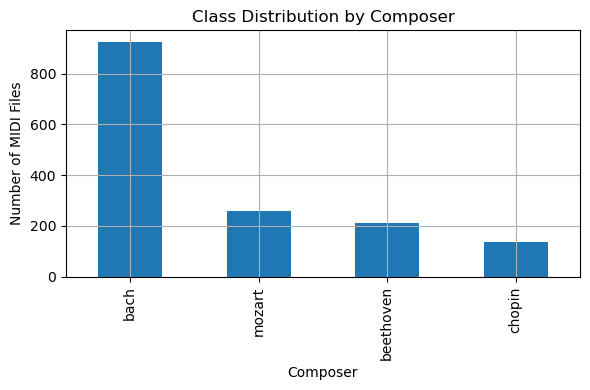

,filepath,label,composer
0,C:/Greg/MSAI/AAI_511/FINAL/Dataset-Group-3/Dat...,0,bach
1,C:/Greg/MSAI/AAI_511/FINAL/Dataset-Group-3/Dat...,0,bach
2,C:/Greg/MSAI/AAI_511/FINAL/Dataset-Group-3/Dat...,0,bach
3,C:/Greg/MSAI/AAI_511/FINAL/Dataset-Group-3/Dat...,0,bach
4,C:/Greg/MSAI/AAI_511/FINAL/Dataset-Group-3/Dat...,0,bach


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pretty_midi
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from tensorflow.keras import Sequential, layers, models, callbacks
from sklearn.utils import class_weight

# Define dataset path
base_dir = "C:/Greg/MSAI/AAI_511/FINAL/Dataset-Group-3/Dataset-Group-3/archive-clean"

# Map folder names to labels
composer_labels = {'bach': 0, 'beethoven': 1, 'chopin': 2, 'mozart': 3}
label_to_name = {v: k for k, v in composer_labels.items()}

# Collect file paths and labels
file_paths = []
labels = []

for composer, label in composer_labels.items():
    folder = os.path.join(base_dir, composer)
    for file in os.listdir(folder):
        if file.endswith('.mid') or file.endswith('.midi'):
            file_paths.append(os.path.join(folder, file))
            labels.append(label)

# Create DataFrame
df = pd.DataFrame({'filepath': file_paths, 'label': labels})
df['composer'] = df['label'].map(label_to_name)

# Plot class distribution
composer_counts = df['composer'].value_counts()
composer_counts.plot(kind='bar', title='Class Distribution by Composer', figsize=(6,4))
plt.xlabel('Composer')
plt.ylabel('Number of MIDI Files')
plt.grid(True)
plt.tight_layout()
plt.show()

df.head()

## Implement Bidirectional LSTM (BiLSTM) to Classify Composers

## BiLSTM Step 3A: Feature Extraction – Pianoroll Representation

To extract meaningful musical structure from MIDI files, we convert them into **pianoroll matrices**. A pianoroll is a 2D matrix where:
- Rows represent MIDI pitches (typically 0–127)
- Columns represent time steps (e.g., 10ms increments)

Each element of the matrix indicates whether a note is being played at that pitch and time.

We will:
1. Load the MIDI file using `pretty_midi`
2. Create a pianoroll for a fixed number of time steps (e.g., 128x128)

In [2]:
# BiLSTM MIDI to pianoroll conversion function (returns TensorFlow tensor)
# Input midi file, sampling frquency 16 frames per second, max extract time 8 seconds
def midi_to_pianoroll(filepath, fs=16, duration=8):
    """
    Converts a midi file to a fixed-size pianoroll matrix (128 pitches x fixed time steps).
    Args:
        filepath (str): Path to MIDI file.
        fs (int): Sampling frequency (frames per second).
        duration (float): Max duration to extract in seconds.
    Returns:
        tf.Tensor: Tensor of shape (1, 128, time_steps)
    """
    # Start try-except block to handle potential errors 
    try:
        # Load midi file
        midi = pretty_midi.PrettyMIDI(filepath)
        # Extract piano roll matrix
        piano_roll = midi.get_piano_roll(fs=fs)
        # Calculate max number of time steps
        max_steps = int(fs * duration)
        # Check for max allowed time steps
        if piano_roll.shape[1] < max_steps:
            # If shorter than max, then pad with zeroes
            padded = np.zeros((128, max_steps), dtype=np.float32)
            padded[:, :piano_roll.shape[1]] = piano_roll
        else:
            # Truncate to max time steps
            padded = piano_roll[:, :max_steps]
        # Normalize velocity values using max midi velocity
        padded = np.clip(padded / 127.0, 0.0, 1.0).astype(np.float32)
        # Convert padded array to a TensorFlow tensor Shape: (1, 128, time)
        return tf.convert_to_tensor(padded)[tf.newaxis, ...]
    except Exception as e:
        # if error with midi file, display error message
        print(f"❌ Failed to process {filepath}: {e}")
        return None

## BiLSTM Step 3B: Visualize Sample Pianoroll Matrix

We’ll select one MIDI file and visualize its pianoroll. This helps confirm:
- Pitch activity is correctly captured
- Temporal length is consistent
- Sparsity and density match musical intuition

The pianoroll will be plotted as a 2D image (Pitch × Time).

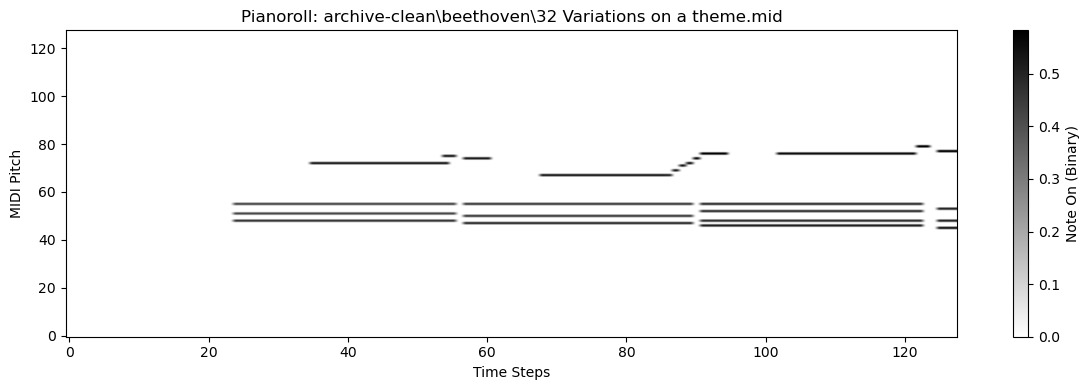

In [3]:
# Sample Pianoroll Visualization
# Get Beethoven midi file in dataset
sample_path = df[df['composer'] == 'beethoven']['filepath'].iloc[0]
# Convert midi file to a fixed-size pianoroll tensor
sample_roll = midi_to_pianoroll(sample_path, fs=16, duration=8)
# If pianoroll sample conversion successful
if sample_roll is not None:
    plt.figure(figsize=(12, 4))
    # Display the pianoroll tensor as a 2D image using reversed grayscale
    plt.imshow(tf.squeeze(sample_roll, axis=0), aspect='auto', origin='lower', cmap='gray_r')
    plt.title(f"Pianoroll: {sample_path.split('/')[-1]}")
    plt.xlabel("Time Steps")
    plt.ylabel("MIDI Pitch")
    plt.colorbar(label='Note On (Binary)')
    plt.tight_layout()
    plt.show()
else:
    print("Failed to generate pianoroll.")

## BiLSTM Step 3C: Batch Feature Extraction – Pianoroll Dataset Preparation

We now apply our pianoroll extraction function to all MIDI files in the dataset. This gives us:
- Input tensors (1×128×128) for each file
- Corresponding composer labels (as integers)

We'll skip and log any failed conversions (e.g., corrupted or unreadable files).

In [4]:
# Extract features and labels from the midi dataset
X, y = [], []

# Loop through each row in the dataset
for idx, row in tqdm(df.iterrows(), total=len(df)):
    # Call the function to convert midi file to pianoroll and return TensorFlow tensor
    roll = midi_to_pianoroll(row['filepath'])
    # Ensure conversion was successful
    if roll is not None:
        # Convert tensor to array, reshape, append to the list
        X.append(np.squeeze(roll.numpy(), axis=0).T)
        # Append label for midi file
        y.append(row['label'])

# Convert 2D array to 3D array
X = np.stack(X)
# Convert labels to 1D array
y = np.array(y)
# Display shape
print("Data shape:", X.shape)

 32%|███▏      | 495/1531 [00:14<01:09, 14.99it/s]C:\Users\gregm\anaconda3\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
 61%|██████    | 932/1531 [01:27<00:57, 10.44it/s]

❌ Failed to process C:/Greg/MSAI/AAI_511/FINAL/Dataset-Group-3/Dataset-Group-3/archive-clean\beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


 86%|████████▋ | 1322/1531 [03:50<00:32,  6.40it/s]

❌ Failed to process C:/Greg/MSAI/AAI_511/FINAL/Dataset-Group-3/Dataset-Group-3/archive-clean\mozart\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


100%|██████████| 1531/1531 [05:08<00:00,  4.97it/s]


Data shape: (1529, 128, 128)


## BiLSTM Step 4: Create TensorFlow Datasets for Train, Validation, Test

To evaluate BiLSTM model performance fairly, split the dataset into:
- Training set: used to learn model weights
- Validation set: used to tune hyperparameters and prevent overfitting
- Test set: used only for final evaluation

We apply stratified sampling to preserve class balance across splits.

In [5]:
# Create TensorFlow Datasets for Train, Validation, and Test
# Split Dataset into 70% Training and 30% Temporary, preserve class distribution
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# Split Temporary data to 50% Validation and 50% Test data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create TensorFlow Datasets
# Set batch size to 32 samples for training
batch_size = 32
# Create TensorFlow dataset for training, shuffle data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
# Create TensorFlow dataset for validation, no shuffling
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
# Create TensorFlow dataset for testing, no shuffling
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Display dataset shapes
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")

Train: (1070, 128, 128), (1070,)
Val:   (229, 128, 128), (229,)
Test:  (230, 128, 128), (230,)


## BiLSTM Step 5: Address Class Imbalance Using Class Weights

The dataset is heavily skewed toward Bach. To mitigate this, we compute `class_weight` based on the frequency of each class. These weights are used in the loss function so the model penalizes errors on underrepresented classes more strongly.

This allows the model to learn from all data without discarding or duplicating samples.

In [6]:
# Calculate weights for each class in training set for class imbalance, prioritize minority classes
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# Convert weights to dictionary, maps each class index to weights
class_weight_dict = dict(enumerate(weights))

# Display class weights
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.4134466769706337, 1: 1.7953020134228188, 2: 2.8157894736842106, 3: 1.494413407821229}


## BiLSTM Step 6: Define BiLSTM Architecture for Composer Classification

We design a bidirectional Long Short-Term Memory architecture to classify pianoroll matrices into 4 composer classes.

The architecture includes:
- 1 Input layer
- 2 Bidirectional LSTM layers with 64 units
- 2 Batch Normalization layers
- 3 Dropout layers (30%) for regularization
- 1 Fully connected (dense) layer with ReLU activation function
- 1 Dense output layer


In [7]:
# Create BiLSTM Model
# Determine how many unique classes
num_classes = len(composer_labels)

# Define a Keras Sequential BiLSTM model with BatchNorm and Dropout
# BiLSTM goes forward and backward through the sequence to learn context from both directions
model = Sequential([
    # Specify the input shape for the model
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    # Add a bidirectional LSTM layer using 64 units, ouput full sequence for each input
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    # Use batch normalization layer for previous output to improve learning
    layers.BatchNormalization(),
    # Add 30% dropout regularization (30% units to 0)
    layers.Dropout(0.3),
    
    # Add 2nd bidirectional LSTM layer with 64 units
    layers.Bidirectional(layers.LSTM(64)),
    # Normalization layer for previous output to improve learning
    layers.BatchNormalization(),
    # Add another dropout layer for 30% regularization
    layers.Dropout(0.3),
    
    # Add fully connected (dense) layer with 64 units and ReLU activation function
    layers.Dense(64, activation='relu'),
    # Add another dropout layer for 30% regularization to reduce risk of overfitting
    layers.Dropout(0.3),
    # Add final output layer using softmax activation
    layers.Dense(num_classes, activation='softmax')
])

## BiLSTM Step 7: Compile and Display the BiLSTM Model

Compile the BiLSTM using the following setup:
- **Loss Function**: sparse_categorical_crossentropy loss
- **Optimizer**: Adam
- **Batch Size**: 32
- **Metrics Tracked**: Train and Validation Loss, Accuracy


In [8]:
# Compile and Display the BiLSTM Model
# Use Adam optimizer to adapt learning rates, compute accuracy for metrics
# Use the loss function sparse_categorical_crossentropy for multi-class classification
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,172 (809.27 KB)

 Trainable params: 206,660 (807.27 KB)

 Non-trainable params: 512 (2.00 KB)

## BiLSTM Step 8: Train the BiLSTM Model

We train the BiLSTM model for 50 epochs and track performance:
- Training loss and accuracy
- Validation loss and accuracy
- Use computed `class_weights`


In [9]:
# Use fit method to start model training and store training details
history = model.fit(
    # Dataset used for training model for each epoch
    train_dataset,
    # Dataset to evaluate performance for each epoch
    validation_data=val_dataset,
    # Number of passes through entire dataset
    epochs=50,
    # Mapping classes to weights, giving priority to minority classes
    class_weight=class_weight_dict,
    # Display loss, accuracy, val_loss, val_accuracy
    verbose=1
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.2881 - loss: 1.7162 - val_accuracy: 0.5764 - val_loss: 1.3214
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.4137 - loss: 1.2917 - val_accuracy: 0.5895 - val_loss: 1.2777
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.4877 - loss: 1.2196 - val_accuracy: 0.5764 - val_loss: 1.2422
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.4880 - loss: 1.1373 - val_accuracy: 0.5590 - val_loss: 1.1999
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.5239 - loss: 1.0679 - val_accuracy: 0.5633 - val_loss: 1.1683
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.5972 - loss: 0.9283 - val_accuracy: 0.5590 - val_loss: 1.1349
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.5772 - loss: 0.9242 - val_accuracy: 0.6114 - val_loss: 1.0401
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.6478 - loss: 0.7773 - val_accuracy: 0

## BiLSTM Step 9: BiLSTM Training Curve Visualization

We now plot the training and validation loss and accuracy over 50 epochs to assess model convergence and detect overfitting.

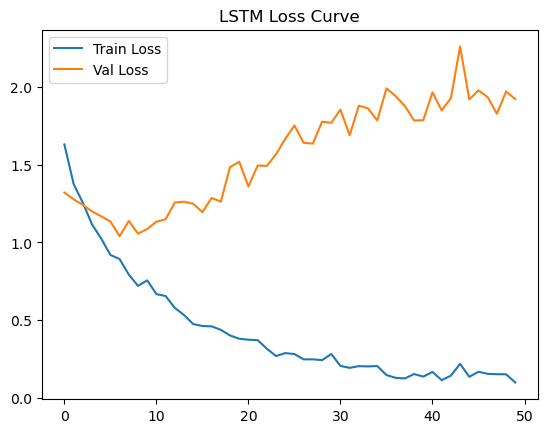

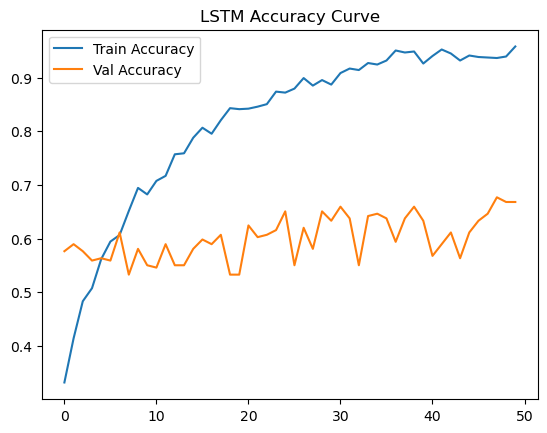

In [10]:
# Plot BiLSTM learning curves
# Plot BiLSTM training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("LSTM Loss Curve")
plt.legend()
plt.show()

# Plot BiLSTM training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("LSTM Accuracy Curve")
plt.legend()
plt.show()

## BiLSTM Step 10: BiLSTM Final Evaluation on Test Set

Evaluate trained BiLSTM model on test dataset, make predictions, and visualize classification performance
We compute:
- Accuracy
- Precision, Recall, F1-score per class
- Confusion Matrix


BiLSTM Test accuracy: 0.6913
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step

BiLSTM Classification Report:
              precision    recall  f1-score   support

        bach       0.87      0.86      0.86       139
   beethoven       0.45      0.66      0.53        32
      chopin       0.39      0.45      0.42        20
      mozart       0.43      0.26      0.32        39

    accuracy                           0.69       230
   macro avg       0.54      0.55      0.53       230
weighted avg       0.69      0.69      0.69       230



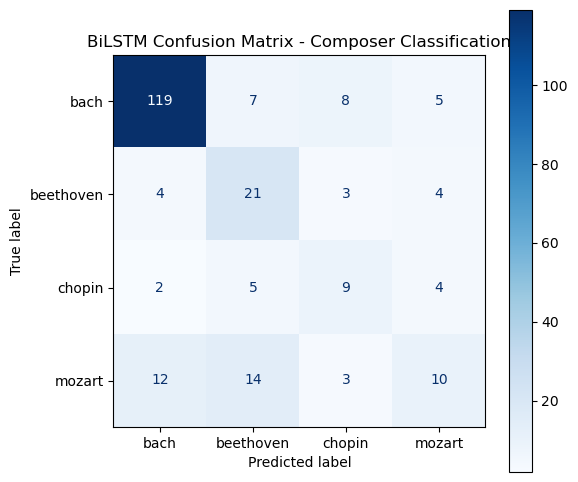

In [11]:
# Evaluate BiLSTM model on test dataset, make predictions
# Evaluate on test set, display accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nBiLSTM Test accuracy: {test_acc:.4f}")

# Predict classe probabilities with BiLSTM model using TensorFlow test dataset
y_pred = model.predict(test_dataset)
# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get True labels test_dataset, align true labels with predictions
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Display classification report: Precision, Recall, F1-score, Support
# Precision: predicted samples of the label, proportion that is truly of that label
# Recall: true samples of the label, proportion the model correctly identified
# F1-score: harmonic mean of precision and recall
# Support: number of true instances for each label in the dataset
print("\nBiLSTM Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=list(composer_labels.keys())))

# Calculate confusion matrix showing count of true vs predicted labels for each label class
cm = confusion_matrix(y_true, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(composer_labels.keys()))
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("BiLSTM Confusion Matrix - Composer Classification")
plt.show()

## BiLSTM Summary  
  
A BiLSTM model was created, trained, and evaluated for performance metrics for composer classification using TensorFlow and the Kaggle musical scores and composers dataset. There were four different composers targeted for classification: Bach, Beethoven, Chopin, Mozart. The results are listed below. The BiLSTM performance for Test accuracy was 0.6913 which is not great performance for the BiLSTM model but only moderate performance. The dataset was imbalanced with much more Bach musical data than the other three composers, so the performance of the model overall was much better in classifying Bach music due to more data to train on. From there classifying Beethoven, the model performance decreased followed by classifying Mozart, and finally classifying Chopin. Based on initial performances and tuning parameters, we decided to work on improving the CNN model only for best composer classification model.  
  
               precision    recall  f1-score  
         bach       0.87      0.86      0.86  
    beethoven       0.45      0.66      0.53  
       chopin       0.39      0.45      0.42  
       mozart       0.43      0.26      0.32  
